In this example, we reconstruct one part of MNIST digits given another part. This is a demonstration of the approach introduced in https://arxiv.org/abs/1904.10387

In [1]:
num_feat = 800   # we are looking for that many most relevant features
max_epoch = 400  

fast = False    # if false, uses Moore-Pensrose pseudo inverse
fudge = 0.0     # regulator for the covariance matrix inverse if fast == True

batch_size = 20000

load = False

In [2]:
# get rid of all the warnings
import os, warnings
warnings.simplefilter("ignore", category=FutureWarning)
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import keras;
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import numpy.linalg as nl
import tensorflow.linalg as tl
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, concatenate, Lambda, ZeroPadding2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Our consists of two sub-areas of MNIST digits. For convenience, we actually use the whole images, but our two neural nets will be "looking" at different parts of it.

In [3]:
mnist = tf.keras.datasets.mnist;
(train_images, train_labels), (test_images, test_labels) = mnist.load_data();
train_images = train_images.reshape(-1,28,28,1).astype(np.float32)/255.0
test_images = test_images.reshape(-1,28,28,1).astype(np.float32)/255.0

# keras really wants us to have targets, so let's make some dummy ones
dummy = np.zeros(len(train_images))
test_dummy = np.zeros(len(test_images))
    
# we agument the data to make it a bit harder
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=3.0,
    height_shift_range=1.5)

import copy 
test_datagen = copy.deepcopy(datagen)
datagen.fit(train_images)
test_datagen.fit(test_images)

# defines which part of the image will be looked at by each net
x_mask = np.zeros((28,28),dtype=np.bool)
y_mask = np.ones((28,28),dtype=np.bool)
x_mask[:,15:] = True
y_mask[:,14:] = False



11493376/11490434 [==============================] - 0s 0us/step


Let's see that this is correct:

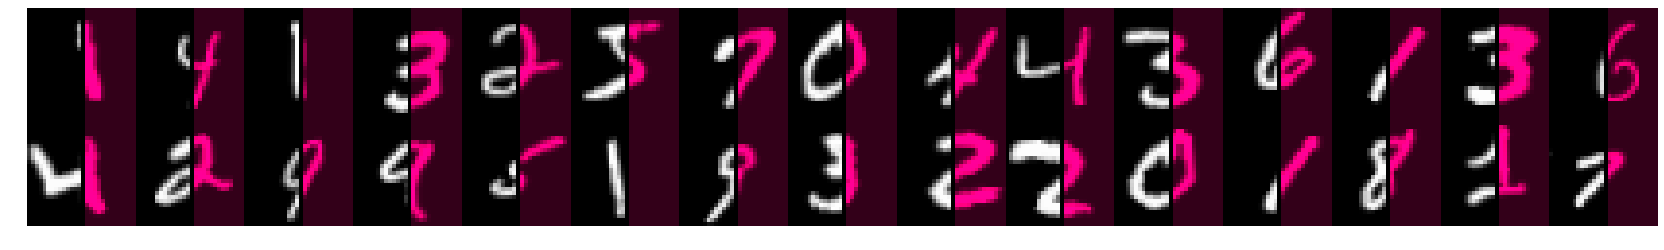

In [4]:
def show_images(pairs):
    n = len(pairs)
    width = 15
    rows = (n-1) // width + 1
    cols = min(n, width)
    bigim = np.zeros((28*rows, 28*cols, 3), np.float32)
    fig = plt.figure(figsize=(2*cols, 2*rows))
    for (j,(x,y)) in enumerate(pairs):
        im = np.zeros((28,28,3))
        im[x_mask,0:1] = x[x_mask]+0.2
        im[x_mask,2:3] = x[x_mask]*0.5+0.1
        im[y_mask,:] = y[y_mask]
        a = (j % width)*28
        b = (j // width)*28
        bigim[b:b+28,a:a+28,:] = im
        
    plt.imshow(bigim)
    plt.axis('off')
    
num = 30
examples = datagen.flow(train_images[:num], dummy[:num], batch_size=num)[0][0]
    
show_images([(examples[i], examples[i]) for i in range(num)])


We build two convolutional neural nets, each looking at a different part of the image (defined by mask1 and mask2). 

In [5]:
def build_model():
    def cnn(image, mask):
        x = Lambda(lambda y: y * mask)(image)
        x = Conv2D(32, kernel_size=(3, 3), strides=(1,1), activation='relu')(x)
        x = Conv2D(64, kernel_size=(4, 4), strides=(2,2), activation='relu')(x)
        x = Conv2D(64, kernel_size=(3, 3), strides=(1,1), activation='relu')(x)
        x = Conv2D(128, kernel_size=(4, 4), strides=(2,2), activation='relu')(x)
        x = Flatten()(x)
        x = Dense(1024, activation='relu')(x)
        features = Dense(num_feat, activation='tanh')(x)
        return features

    image = Input(shape=(28,28,1))
    out1 = cnn(image, x_mask.astype(np.float32).reshape((28,28,1)))
    out2 = cnn(image, y_mask.astype(np.float32).reshape((28,28,1)))

    # We will use each models separately for predictions...
    feat1 = Model(inputs=image, outputs=out1)
    feat2 = Model(inputs=image, outputs=out2)

    # ...but together for training as they have a joint loss function
    model = Model(inputs=image, outputs=concatenate([out1, out2], axis=1))
    
    return feat1, feat2, model

Here are the functions implementing the RFA objective as well as the inference step:

In [6]:
def tf_prep(T):
    z = tf.math.sqrt(tf.cast(tf.shape(T)[0], tf.float64))
    return tf.cast(T, tf.float64)/z
    
def prep(T):
    z = np.sqrt(T.shape[0])
    return T.astype(np.float64)/z

if fast:
    def pinv(T):
        D = fudge * tf.eye(tf.shape(T)[0], dtype = tf.float64)
        return tl.inv(T + D)
else:
    import tensorflow_probability as tfp
    pinv = tfp.math.pinv

@tf.custom_gradient
def tf_relevance(F, G):  
    F = tf_prep(F)
    G = tf_prep(G)
    D = fudge * tf.eye(tf.shape(F)[1], dtype = tf.float64)

    iK = pinv(tl.transpose(F) @ F)
    iL = pinv(tl.transpose(G) @ G)
    
    A = tl.transpose(F) @ G
    U = iK @ A
    V = iL @ tl.transpose(A)

    dF = 2 * (G - F @ U) @ V @ iK
    dG = 2 * (F - G @ V) @ U @ iL
    grad = lambda delta: (tf.cast(delta * dF, tf.float32), tf.cast(delta * dG, tf.float32))
        
    return tl.trace(U @ V), grad

def cov(F, G):
    F = prep(F)
    G = prep(G)
    return (np.transpose(F) @ F, 
            np.transpose(G) @ G, 
            np.transpose(F) @ G)
    

# produces a function that maps a vector of features on X to the inferred (expected) value of Y
# More generally, Y can be the value of any function f of Y applied to each training example. 
# It's shape is (num training example, a,b,...) where (a,b,...) is the shape of the output of f.
def inferY(ker, G, Y):  
    n, k = F.shape
    data_shape = Y.shape[1:]
    
    K, L, A = ker
    Y = prep(Y).reshape((n,-1))
    G = prep(G)
    
    M = (np.transpose(Y) @ G) @ nl.solve(L, np.transpose(A)) 
    iK = nl.pinv(K)

    def infer(tF):
        X = np.transpose(M @ (iK @ np.transpose(tF))) 
        return X.reshape((-1,) + data_shape)
    
    return infer

# produces a function which maps a vector of features on Y to the inferred (expected) value of X
def inferX(ker, F, X): 
    K, L, A = ker
    return inferY((L, K, np.transpose(A)), F, X)

def singvals(ker):
    K, L, A = ker
    M = nl.solve(K, A) @ nl.solve(L, np.transpose(A))
    return sorted(nl.eigvals(M), reverse=True)
    
def RFA_Loss():
    def loss(dummy, features):
        F, G = tf.split(features, 2, axis=1)
        return -tf_relevance(F, G) 
    return loss

It's time to learn the correlations!

In [7]:
feat1, feat2, model = build_model()

model.compile(optimizer = Adam(lr=0.001), loss = RFA_Loss())

if load:
    model.load_weights('../input/rfa-mnist-weights/best_weights.h5')
else:
    callbacks = [
        ModelCheckpoint('best_weights.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True, save_weights_only=True),
        EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=2)
    ]
    
    train_data = datagen.flow(train_images, dummy, batch_size=batch_size, shuffle=True)
    test_data = test_datagen.flow(test_images, test_dummy, batch_size=batch_size)
    
    model.fit_generator(train_data, steps_per_epoch = len(train_images) / batch_size,
                        epochs = max_epoch, verbose=2,
                        callbacks = callbacks,
                        validation_data = test_data, validation_freq = 5)
    
    model.save_weights('last_weights.h5')
    model.load_weights('best_weights.h5')

Epoch 1/400
3/3 - 30s - loss: -6.1044e+01
Epoch 2/400
3/3 - 20s - loss: -7.3548e+01
Epoch 3/400
3/3 - 20s - loss: -8.2314e+01
Epoch 4/400
3/3 - 19s - loss: -9.1349e+01
Epoch 5/400
3/3 - 32s - loss: -1.0108e+02 - val_loss: -1.3562e+02
Epoch 6/400
3/3 - 17s - loss: -1.1161e+02
Epoch 7/400
3/3 - 19s - loss: -1.2275e+02
Epoch 8/400
3/3 - 19s - loss: -1.3431e+02
Epoch 9/400
3/3 - 19s - loss: -1.4544e+02
Epoch 10/400
3/3 - 30s - loss: -1.5647e+02 - val_loss: -1.8617e+02
Epoch 11/400
3/3 - 17s - loss: -1.6647e+02
Epoch 12/400
3/3 - 19s - loss: -1.7685e+02
Epoch 13/400
3/3 - 19s - loss: -1.8575e+02
Epoch 14/400
3/3 - 20s - loss: -1.9469e+02
Epoch 15/400
3/3 - 30s - loss: -2.0220e+02 - val_loss: -2.2652e+02
Epoch 16/400
3/3 - 17s - loss: -2.1100e+02
Epoch 17/400
3/3 - 19s - loss: -2.1841e+02
Epoch 18/400
3/3 - 19s - loss: -2.2535e+02
Epoch 19/400
3/3 - 19s - loss: -2.3149e+02
Epoch 20/400
3/3 - 29s - loss: -2.3866e+02 - val_loss: -2.5963e+02
Epoch 21/400
3/3 - 17s - loss: -2.4547e+02
Epoch 22/4

We compute the best features on the full training set

In [8]:
F = feat1.predict(train_images, batch_size=1000, verbose=0)
G = feat2.predict(train_images, batch_size=1000, verbose=0)
ker = cov(F, G)

A little consistency check: we compute the singular values using different random batches. The result shouldn't depend too much on the sample size. This screens for a failure mode in which the objective is independent of the sample for a given sample size, but highly dependent on the sample size.

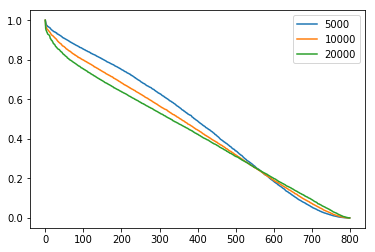

In [9]:
if not load:
    for n in [5000, 10000, 20000]:
        sample = np.random.choice(F.shape[0], n)
        plt.plot(np.abs(singvals(cov(F[sample], G[sample]))), label=str(n))
    
    plt.legend();


Last use of our training data: to produce the inference maps.

In [10]:
# make function that predicts conditional mean of pixel value
infer = inferY(ker, G, train_images * y_mask.reshape((28,28,1)))

# and the mean of the square of the pixel values
infer2 = inferY(ker, G, (train_images * y_mask.reshape((28,28,1)))**2)

Let's graph the singular values evaluated on test data

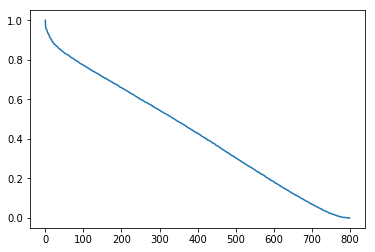

In [11]:
tF = feat1.predict(test_images, batch_size=1000, verbose=0)
tG = feat2.predict(test_images, batch_size=1000, verbose=0)
tker = cov(tF, tG)
plt.plot(np.abs(singvals(tker)), label=str(n));


Finally, we can try inferring one part of test images given their other part (in red). These are meant to be averages over all possibilities, not samples from the conditional distributions.

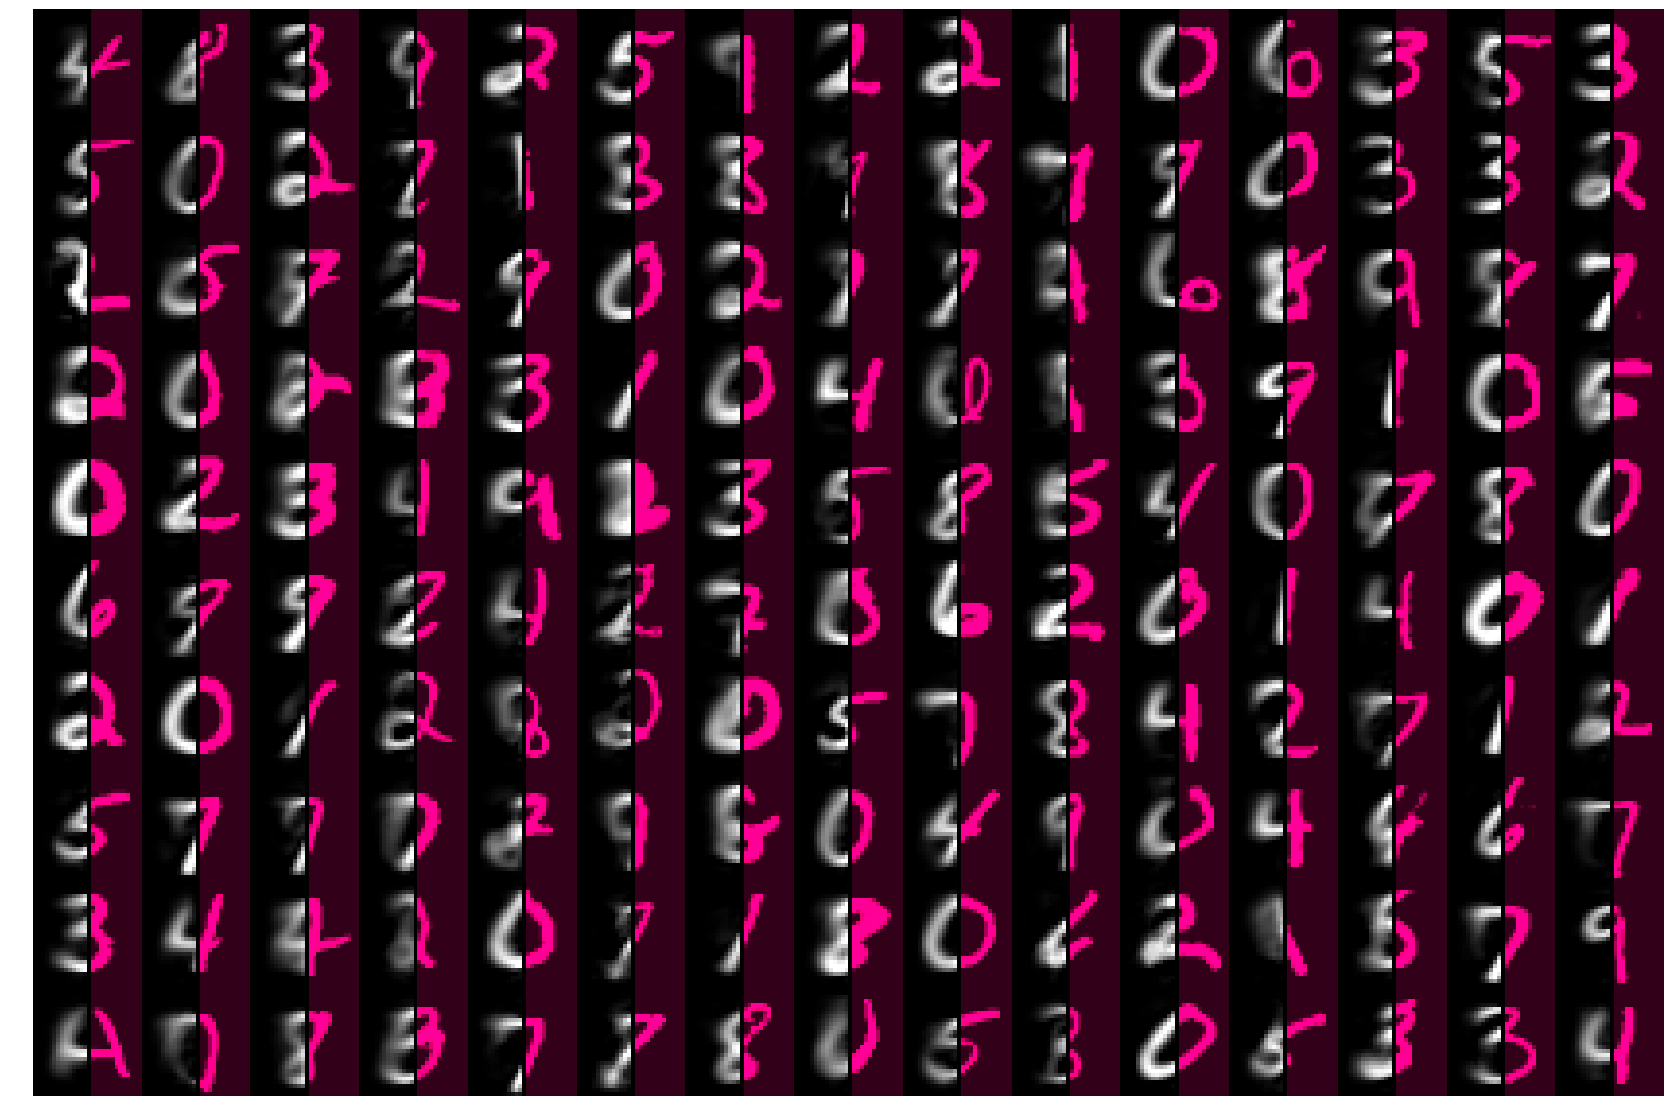

In [12]:
# try it on a sample of test images
np.random.seed(1337)
samples = np.random.choice(test_images.shape[0], size=15*10, replace=False)

y_pred = infer(tF[samples])
show_images(list(zip(test_images[samples], y_pred))) 

Okay, but maybe a traditional feed-forward encode-decoder might have done just as well. However, we have a full probabilist model. For instance, let us check the uncertainty on each pixel values:

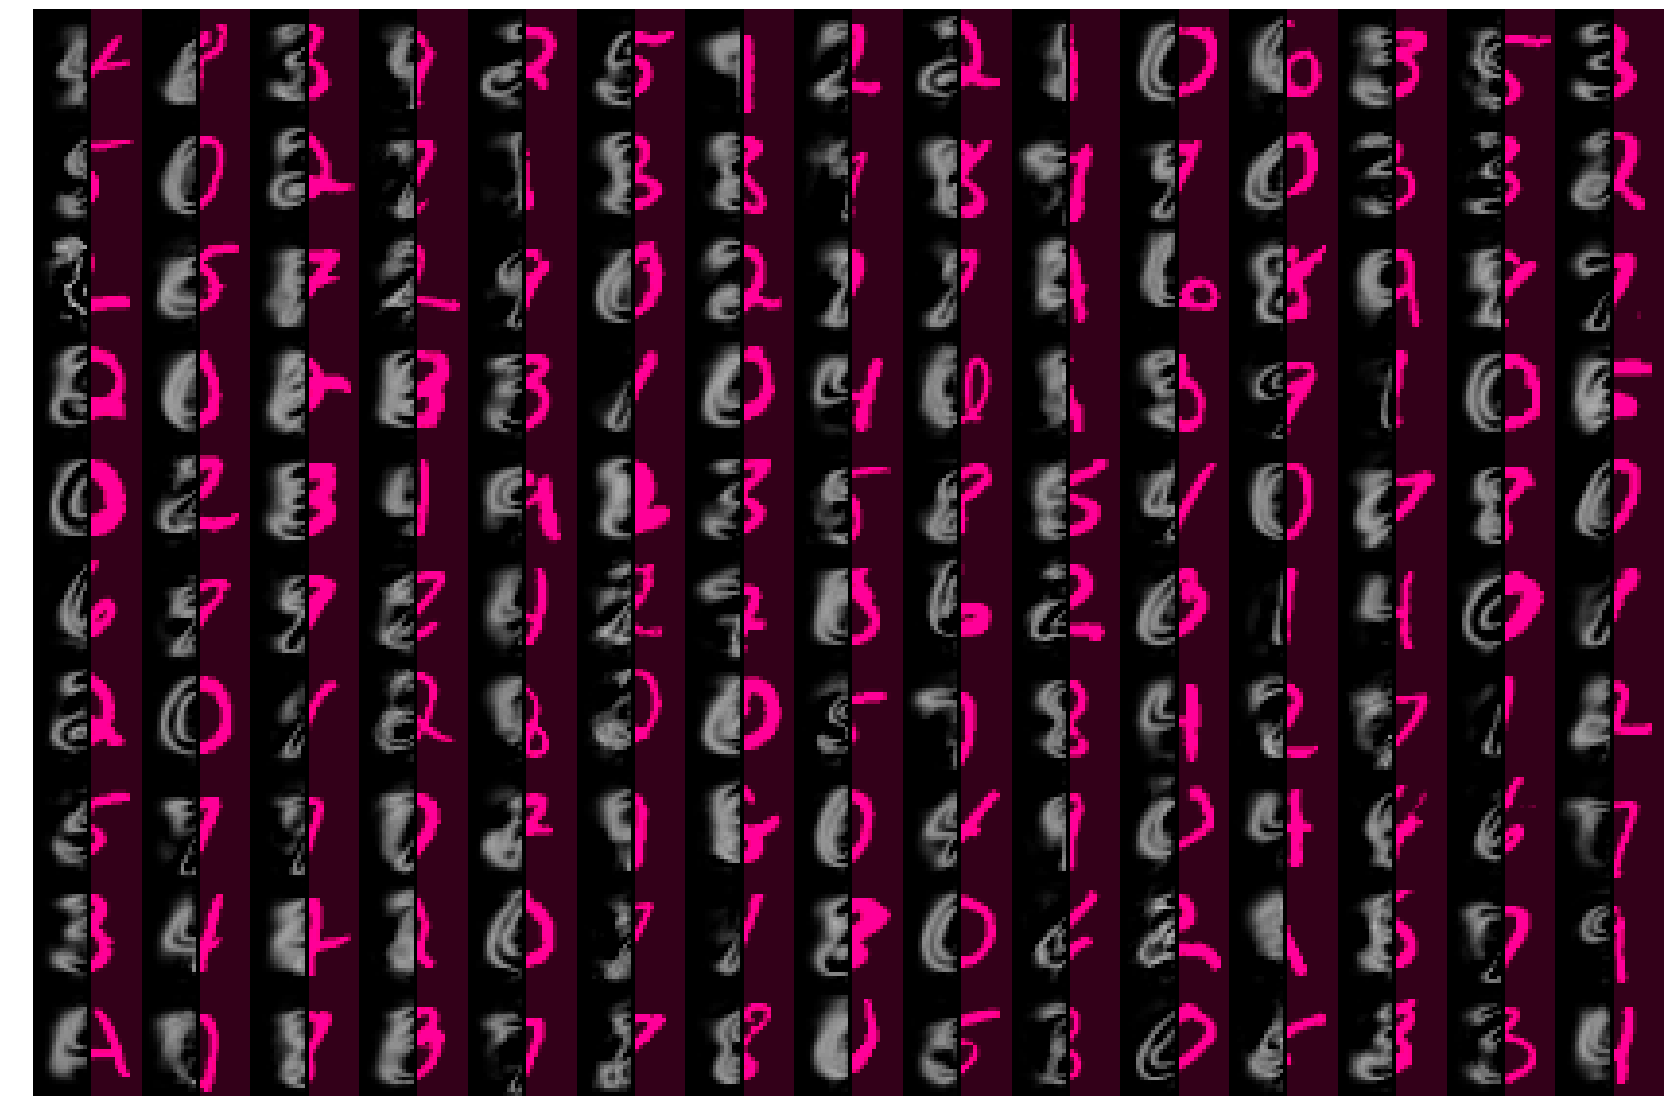

In [13]:
y2_pred = infer2(tF[samples])

# that allows us to compute the standard deviations
dev = y2_pred - y_pred**2
show_images(list(zip(test_images[samples], dev*3)))